# Heat equation - MVP

The McLachlan Variational Principle can be used both numerically and analytically if the ansatz is expressive enough.

Here use a Gaussian Ansatz ($A(t),\sigma(t)$)

$$
v = A ~ \exp\left( - \dfrac{(x-0.5)^2}{2\sigma^2} \right)
$$

to track the dynamics of the heat equation.

Check step-by-step solved example calculations in the paper for parameters $A(t),\sigma(t)$.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pickle
from numpy import exp, sqrt, pi, log
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
# parameters
nqubits = 6
tdim = 200
tmax = 40.0
sigma0 = 0.01

# spatial resolution
gmlst = np.linspace(0,1,2**nqubits) #[] energy array
dx = gmlst[1]-gmlst[0]
# time resolution
dt = tmax/tdim
L = 1
dx = L/(2**nqubits)
Lmatrix = np.zeros((2**nqubits,2**nqubits),dtype=complex)
for i in range(2**nqubits):
    for j in range(2**nqubits):
        if i==j:
            Lmatrix[i,j] = -2
        if i%(2**nqubits)==(j+1)%(2**nqubits) or i%(2**nqubits)==(j-1)%(2**nqubits):
            Lmatrix[i,j] = +1

In [3]:
# analytical solution 1/sqrt(4*pi*k*t) * exp(-x**2/(4*k*t))
def uans(theta):
    """ wavefunction """
    A, sigma = theta
    yth = A * exp(-0.5*(gmlst-0.5)**2/sigma**2)
    return yth #/sqrt(np.sum(np.abs(yth)**2))

def dudth(A, sigma):
    """ wavefunction derivatives """
    dx = 1e-4
    dpsi0 = (uans([A+dx, sigma])-uans([A-dx, sigma]))/(2*dx)
    dpsi1 = (uans([A, sigma+dx])-uans([A, sigma-dx]))/(2*dx)
    return dpsi0, dpsi1

def get_dthetadt(theta):
    """ compute Mkj and Vk elements, and solve matrix equation for derivative of variational parameters """
    A, sigma = theta
    Mkj = np.zeros((2,2))
    Vk = np.zeros(2)
    
    psi = uans(np.array([A, sigma]))
    dpsi0, dpsi1 = dudth(A, sigma)
    Mkj[0,0] = np.sum( dpsi0 * dpsi0 )
    Mkj[0,1] = np.sum( dpsi0 * dpsi1 )
    Mkj[1,0] = Mkj[0,1]
    Mkj[1,1] = np.sum( dpsi1 * dpsi1 )
    
    Vk[0] = np.real( np.vdot( dpsi0, Lmatrix @ psi ) )
    Vk[1] = np.real( np.vdot( dpsi1, Lmatrix @ psi ) )

    return np.linalg.lstsq(Mkj, Vk)[0] # least squares to avoid numerical instabilities in matrix system

In [4]:
# initial target distribution
f0 = exp(-0.5*((gmlst-0.5)/(sigma0) )**2) # * np.heaviside(1800-gmlst,0) # 1*dx*g0
f0_target = f0/sqrt(np.sum(np.abs(f0)**2))
A0 = 1/sqrt(np.sum(np.abs(f0)**2))

# solve PDE
fPDElst = np.zeros((tdim,2**nqubits))
fPDE = np.real( np.copy( f0_target ) )
for i in trange(tdim):
    fPDElst[i,:] = fPDE
    fPDE += dt * (np.real(Lmatrix) @ fPDE)

# solve MVP
theta = np.array([A0, sigma0])
thetalst = np.zeros((tdim,2))
for i in trange(tdim):
    thetalst[i,:] = theta
    theta = theta + get_dthetadt(theta) * dt

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3009.07it/s]


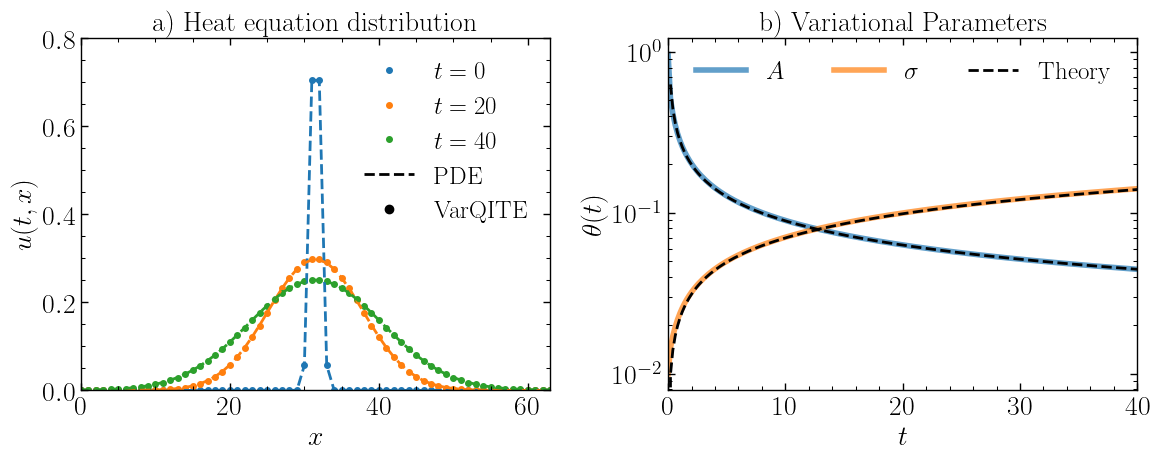

In [11]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2,5))

t = tmax*0.0; i = int(t/tmax * tdim);
yth = np.real( uans(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot( yth, 'o', label=r'$t={:.0f}$'.format(t), color='tab:blue', markersize=4 )
t = tmax*0.5; i = int(t/tmax * tdim);
yth = np.real( uans(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot( yth, 'o', label=r'$t={:.0f}$'.format(t), color='tab:orange', markersize=4 )
t = tmax*0.9999; i = int(t/tmax * tdim);
yth = np.real( uans(thetalst[i,:]) ); yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot( yth, 'o', label=r'$t={:.0f}$'.format(t), color='tab:green', markersize=4 )


yth = fPDElst[0,:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot( yth, '--', color='tab:blue' )
yth = fPDElst[int(tdim/2),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot( yth, '--', color='tab:orange' )
yth = fPDElst[int(tdim*0.99999),:]; yth /= np.sign(np.trapz(yth)); yth /= sqrt(np.sum( np.abs(yth)**2 ))
axes[0].plot( yth, '--', color='tab:green' )

# PDE vs VarQITE
axes[0].plot( yth-100, 'k--', label='PDE' )
axes[0].plot( yth-100, 'ko', label='VarQITE' )

axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$u(t,x)$')
axes[0].legend(frameon=False, fontsize=18)
axes[0].set_ylim([0, 0.8])
#plt.title("Heat equation (symmetric): n={}, #blocks={}, #parameters={}, tdim={}".format(nqubits, klayers, nparams, tdim ))
axes[0].set_title("a) Heat equation distribution ")


# showing the evolution of variational parameters
tlst = np.linspace(0,tmax,tdim)
axes[1].plot(tlst, thetalst[:,0], label=r'$A$', linewidth=4, alpha=0.7)
axes[1].plot(tlst, thetalst[:,1], label=r'$\sigma$', linewidth=4, alpha=0.7)
axes[1].plot(tlst, 1/sqrt(4*pi*tlst), 'k--', label=r'Theory' )
axes[1].plot(tlst, sqrt(2*tlst)*dx, 'k--' )
#plt.xlim([0,50])
axes[1].set_xlabel(r'$t$')
axes[1].set_ylabel(r'$\theta(t)$')
axes[1].set_yscale('log')
#axes[1].set_title(r'b)  Parameters: n={}, tdim={}'.format(nqubits,tdim))
axes[1].set_title(r'b) Variational Parameters')
axes[1].legend(frameon=False, ncol=3, fontsize=18, loc='upper center')

axes[0].set_xlim([0,2**nqubits-1])
axes[1].set_xlim([0,40])
xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes[0].set_aspect(aspect=3/4/axesratio)
#
xmin, xmax = axes[1].get_xlim()
ymin, ymax = axes[1].get_ylim()
axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
axes[1].set_aspect(aspect=3/4/axesratio)

plt.tight_layout()
#plt.savefig("Heat_analytical_MVP.pdf", transparent=True)
plt.show()